In [2]:
import os
import sys
sys.path.append('/data/idvor/python_scripts/')
import baseline, analysis
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import itertools

# Complete notebook to present data for IDVOR
Compiled and fixed by Jason, base code by Sam

The goal of this project is to set the stage for future work using CNNs to model individual differences. A major hurdle in this wider project is how do we measure representational variability in CNNs and how much variability is "significant"? 

Slotting in background stuff here.

While representational similarity between models have been measured using representational similarity analysis (RSA), there are other techniques native to computer science that may be fruitful to use instead. We would like a metric that can quantify the similarity across outputs of CNNs regardless of form and the metric should be robust to noise (ie: pick out the signal). To do this, we will use simuluations to test how each metric performs in cases with clear expected results. By the end of this, we should be able to give specific recommendations on which metric to use and when they are best used.

We will then leverage the metrics to determine the baseline amounts of variability in representations during normal function. As we plan to use CNNs to model sources of variability, we want to know what is the baseline amount of variability in representations found in these networks during normal functioning. Finally, we will apply this baseline to CNN variability caused by changes in randomization seed. Randomization seeds dictating the initial weights and dataset presentation order is the smallset possible changes to CNNs that may result in variability in representations of images and if it produces variability above baseline, it is likely that more significant than this would be fruitful methods to model individual differences.
## Similarity Metrics
We use three different simliarity metrics to measure representational simliarity throughout this project: RSA, CCA, and CKA. Each of these methods are dependent on the dataset that is used to generate output from a specific layer.
Representational Similarity Analysis (RSA): a RDM of pairwise Pearson's correlation between each image is created then the similarity between two sources is indexed by the Pearson's correaltion between their RDMs.

Canonical Correlation Analysis (CCA): Between the representations of a dataset between two sources, a transformation is found such that a correlation is maximized. This is repeated with the constraint that the transformation is orthoganol to the previous. After repetitions equal to the number of features (in the case where the number is not equal, the lower number), the set of correlations is aggregated. I originally used Projection-weighted CCA as it is the latest from the authors but it seems to be bugged. Instead, we use singular vector CCA: essentially, before doing any correlations we select the number of neurons necessary to capture 98% of the variance in the represntation.

Centered Kernel Alignment (CKA): Between the representations of a dataset between the two sources, the Hilbert-Schmidt Independence Criterion is calculated. The HSIC applies a kernel on the centered representations and calculates whether the two representations are statistically independent. This is normalized against the HSIC between the representations and themselves. We use a linear kernel here but other kernels are possible like a RBF.

## Simulation Tests
Through a series of simulation tests, we hope to find which metric performs best in different cases and what researchers should be using to quanitfy CNN representational simialrity.

### Correspondence Test
The first test we use is a correspondence test (Kornblith et al., 2019). Given two instances of a network, differing only in randomization seeds, you can generate representations from an image set at each layer. Ideally, if pairs of representations between the networks were compared, the most similar pair should be the outputs from the corresponding layers, e.g., the output of final layer of one instance should be the most similar to the output of the final layer in another instance. From this, we can test how well each similarity metric performs in finding the corresponding layers across instances of a network.

For this test, we use 100 instances of a relatively simple CNN (All-CNN-C; architecture below) trained on CIFAR10, varying only on randomization seeds. For each possible pair of networks, we tested each metric's ability to find the corresponding layers between the networks based on the outputs of each layer given an image set. We randomly sampled 100 images from each category of the CIFAR10 validation set for this image set. We can look at raw % accuracy as well as confusion matrices to see how each metric performs for each layer.

In [2]:
modelPath = '../outputs/masterOutput/models/w0s0.pb'
print('Loading model')
model = tf.keras.models.load_model(modelPath)
model.summary()

Loading model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 

In [3]:
corres = pd.read_csv('../outputs/masterOutput/correspondence.csv', index_col=0)
corres['rsaCorr'] = corres['do_rsaNumba'] == corres['layer']

# Need to calculate cca and cka accuracy carefully as layers 9 and 8 are equivalent
corres['ccaCorr'] = corres['do_svcca'] == corres['layer']
corres['ckaCorr'] = corres['do_linearCKANumba'] == corres['layer']
corres.loc[corres['layer'] == 8, 'ccaCorr'] = np.isin(corres['do_svcca'].loc[corres['layer'] == 8], [8, 9])
corres.loc[corres['layer'] == 8, 'ckaCorr'] = np.isin(corres['do_linearCKANumba'].loc[corres['layer'] == 8], [8, 9])

rsaAcc = np.sum(corres['rsaCorr']) / len(corres['rsaCorr'])
ccaAcc = np.sum(corres['ccaCorr'].loc[corres['layer'] != 9]) / len(corres['ccaCorr'].loc[corres['layer'] != 9])
ckaAcc = np.sum(corres['ckaCorr'].loc[corres['layer'] != 9]) / len(corres['ckaCorr'].loc[corres['layer'] != 9])

corres.head()

,model1,model2,do_rsaNumba,do_svcca,do_linearCKANumba,layer,rsaCorr,ccaCorr,ckaCorr
0,w6s2,w0s3,0,0,0,0,True,True,True
1,w6s2,w0s3,1,3,1,1,True,False,True
2,w6s2,w0s3,2,3,2,2,True,False,True
3,w6s2,w0s3,3,9,3,3,True,False,True
4,w6s2,w0s3,4,9,4,4,True,False,True


In [4]:
print(f"RSA Correspondence Test Accuracy: {rsaAcc}")
print(f"CCA Correspondence Test Accuracy: {ccaAcc}")
print(f"CKA Correspondence Test Accuracy: {ckaAcc}")

RSA Correspondence Test Accuracy: 0.9917355371900827
CCA Correspondence Test Accuracy: 0.2
CKA Correspondence Test Accuracy: 0.9927070707070708


RSA basically always succeeds, CCA is extremely inaccurate while CKA similarly almost always succeeds. We can look at the confusion matrices to see where the confusions lie.

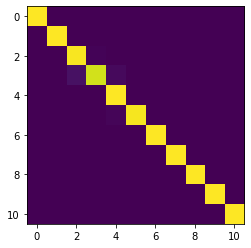

In [5]:
layers = np.unique(corres['layer'])
rsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['do_rsaNumba'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        rsaConfusion[i, index] = tmp[index]

plt.imshow(rsaConfusion)

RSA essentially demonstrates the ideal case, the corresponding layer is found almost every time. What mistakes are made appear to be from layer 3 mistaking it to layer 2. Layer 2 is the first "pooling" layer in these networks so there are relatively few features to work with. These relatively close mistakes would not be as bad as mistaking outputs from layers farther apart. 

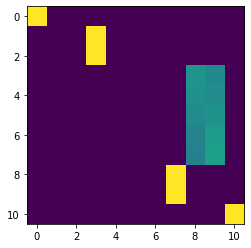

In [6]:
layers = np.unique(corres['layer'])
ccaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['do_svcca'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        ccaConfusion[i, index] = tmp[index]

plt.imshow(ccaConfusion)

Note for CCA, the final two layers are exactly the same in terms of output, this is because whenever the output is 2D (ie: from a convolutional layer), we do global average pooling for each filter to produce a flat representation, the penultimate layer of these networks themselves are global average pooling and therefore is equivalent to the previous layer for CCA. The pooling layer is ommitted in calculating percent accuracy.

As seen here, the CCA confusion matrices show fairly consistent patterns of confusions. The only time CCA suceeds is in the first and final layers. The errors are fairly consistent in the first block of the networks. In the first block, CCA consistently finds that the layers within a block is most simiarly to the first layer of the next block, right after pooling. It appears that the middle convolutional layers are all mismatched with the final layers of the network. This suggests that generally, CCA is biased with matching finding that representations are most similar to these later layers which have far fewer features (in this case, it is 10).

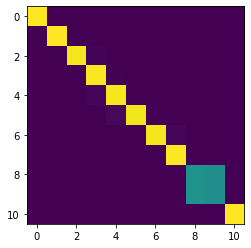

In [7]:
layers = np.unique(corres['layer'])
ckaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['do_linearCKANumba'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        ckaConfusion[i, index] = tmp[index]

plt.imshow(ckaConfusion)

CKA similarly uses global average pooling for the outputs of the convolutional layers and therefore layer 9 and 8 are equivalent. Basically perfect.
### Permutation Tests
Here, instead of directly using outputs from networks to test how well each metric performs, we simulate representations with specific properties which we want to test the effectiveness of each metric. To generate representations with similar distributions to real representations from CNNs, we take the outputs of a single network given an image set and then randomly sample from it to generate "meaningless" representations that we test with. For each test, we repeat the process 10000 times to produce confidence intervals around a mean value. We focus on tests with specific expected (or ideal) results to assess each metric.

We do three permutation tests here:
* Random: a pair of representations are generated by randomly permuting the original representations. This is essentially a pair of meaningless representations which should have no similarity, i.e., simliarity should be 0.
* Noise: a meaningless representation is generated and compared to the same representation with noise added to each feature. The noise is sampled from a normal distribution centered at 0 with a standard deviation equal to the standard deviation of the original representations. While this noise is quite significant, the signal underneath the noise is not entirely gone and therefore the similarity should not be exactly 0 (though it should not be 1 either).
* Ablate: a meaningless representation is generated and compared to the same representation with a randomly chosen column of features removed. Essentially, this is an ablation experiment, cutting out a single neuron. Given that there are 10 features for each images, removing a single neuron would be removing 10% of the information. We would expect a drop in similarity but as the rest of the representations are intact, it should not be far from 1.

In [8]:
# load dataset
imgset = np.load("../outputs/masterOutput/dataset.npy")

# Dataset information
num_imgs = imgset.shape[0]
dim = imgset.shape[1]
correlations = []

# Set model to output reps at layer
inp = model.input
layer = model.layers[12]
out = layer.output

tmpModel = tf.keras.Model(inputs=inp, outputs=out)

# Get reps for originals and flatten
rep_orig = tmpModel.predict(imgset)
repShape = rep_orig.shape
rep_flat = rep_orig.flatten()
repMean = np.mean(rep_flat)
repSD = np.std(rep_flat)

print(imgset.shape)
print(repMean)
print(repSD)


(1000, 32, 32, 3)
0.1
0.29175842


In [9]:
permutePath = '../outputs/masterOutput/permuteSims.csv'
permuteData = pd.read_csv(permutePath)
print(
    f"Random Test",
    f"RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'do_rsaNumba'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'do_rsaNumba'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'do_svcca'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'do_svcca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'do_linearCKANumba'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'do_linearCKANumba'])}",
    '',
    f"Noise Test",
    f"RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'do_rsaNumba'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'do_rsaNumba'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'do_svcca'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'do_svcca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'do_linearCKANumba'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'do_linearCKANumba'])}",
    '',
    f"Ablation Test",
    f"RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'do_rsaNumba'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'do_rsaNumba'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'do_svcca'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'do_svcca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'do_linearCKANumba'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'do_linearCKANumba'])}",
    sep = '\n'
)

Random Test
RSA -- mean 1.977609342017635e-06
SD 2.9146738377307524e-06
CCA -- mean 0.0838453493815464
SD 0.006310950528370817
CKA -- mean 0.00986457787710242
SD 0.0014298527288473797

Noise Test
RSA -- mean 0.06901087487451732
SD 0.0050961278468890665
CCA -- mean 0.7071860470261188
SD 0.004438898804331599
CKA -- mean 0.5057070873892217
SD 0.006286504203299497

Ablation Test
RSA -- mean 0.7721993929982185
SD 0.02632698657119037
CCA -- mean 0.9999999998778679
SD 3.908091843029902e-12
CKA -- mean 0.9492837751419997
SD 0.008351504341354534


In the random test, we expect a similarity of 0. RSA and CKA do relatively well in the random test, essentially returning 0. RSA is much much closer 0 but the diference between RSA and CKA is essentially rounded off. Notably, CCA does not give us exactly 0 with a similarity score of .08 suggesting some spurious correlation being detected. CCA and CKA are notably depdendent on the ratio between the number of input images and the number of features in the outputs, more on this later. 

In the noise test, we expect moderate similarity. In the test with noise added to representations, we see the RSA is heavily affected by the addition of noise, almost falling to 0. CCA and CKA perform much better. CCA is relatively robust to noise with r = .71 and CKA doing worse but still quite reasonable at r = .51. Considering that the magnitude of noise is relatively large, being able to extract a high amount of similarity between the two is stil quite impriessive. The nearly complete failure of RSA in this case is concerning as there is still signal underlying the noise.

In the ablation test, we expect relatively high similarity. Despite only losing 10% of the data, the similarity as indexed by RSA falls to .77. Conversely, CCA and CKA are relatively robust to the loss of a single neuron. CCA using singular vector decomposition on its inputs first and only uses the top n features that capture 99% of the variance in representations, this actually takes 9 features most of the time therefore the loss of a single neuron is not entirely concerning for this metric, which may explain the nearly perfect similarity. CKA only drops slightly and demonstrates itself to be relatively robust to this.

In general, CCA usually returns the highest similarity score between representations regardless of their actual content. This is concerning for cases where no similarity should be found like in the random test. Conversely, RSA usually returns the lowest similarity scores and often estimates significantly lower similarity relative to the other metrics even if a high simliarity is expected as in the ablation test. CKA appears to strike a balance between the two, returning nearly 0 for the random test and nearly 1 for the ablation test. 

### Practical Considerations: Image:Feature Ratio
Another consideration in using these metrics is entirely practical. As the intention is to use CNNs to model individual differences in biological object recognition, biological systems are usually only exposed to relatively few images (less than 100). However, CCA has been noted to be sensitive to the ratio between images and output features where the number of images should vastly outnumber the number of features. As the ratio of between images and features approaches one, the resulting correlations begin to rise even if the representations are completely unrelated, essentially detecting spurious correlations. If we are to use the same images exposed to biological systems in CNNs to generate and compare representations, then this is an important consideration. We will test how each metric performs as we parametrically manipulate the ratio between images and features. We will use the same permutation framework, sampling from a set of real representation to generate simulated representation.

We hold the number of images at 1000 and range the number of features from 50 to 950 at steps of 50. This results in a ratios starting at 20:1 down to nearly 1:1. Note that this procedure is an extended version of the previous section's random test, in the previous section, it is the 100:1 case.

In [10]:
ratioPath = '../outputs/masterOutput/ratioSims.csv'
ratioSims = pd.read_csv(ratioPath)
ratioSims['ratio'] = ratioSims['sample'] / ratioSims['features']

ratios = ratioSims['ratio'].unique()
ratioData = pd.DataFrame(columns=list(ratioSims.columns[0:3]) + ['ratio'], index=range(len(ratios)))
for i, ratio in enumerate(ratios):
    ratioData.loc[i] = list(ratioSims.loc[ratioSims['ratio'] == ratio, ratioSims.columns[0:3]].mean('index')) + [ratio]

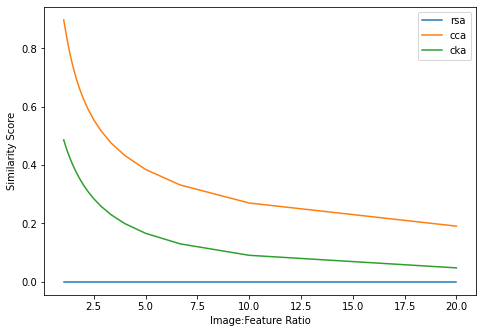

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(ratioData['ratio'], ratioData['do_rsaNumba'], label='rsa')
ax.plot(ratioData['ratio'], ratioData['do_svcca'], label='cca')
ax.plot(ratioData['ratio'], ratioData['do_linearCKANumba'], label='cka')
ax.set_xlabel('Image:Feature Ratio')
ax.set_ylabel('Similarity Score')
ax.legend()

Here we see that RSA is essentially not dependent on the ratio between images and features. However, CCA and RSA are much more dependent on the image:feature ratio. At the nearly 1:1, CKA has a similarity score of 0.5 and CCA has a similarity score of .9. This does quickly drops but even at the 10:1 ratio, it isn't 0. This does not bode well for the use of CCA and CKA for cognitive neuroscience as the size of the representations in modern CNNs dwarfs the amount of images we present to biological systems. 

Note that this analysis might not be correct, this simulation is just an extended version of the random permutation test in the last section where the case there is the 100:1 case. If the data from that point is added on the plot, it'll have a notable discontinuity. This might be caused by the fact that to generate more features relative to the original real representations, we sampled with replacement (as opposed to be without replacement in the 100:1 case) causing many repeats even in the 20:1 case. A possible solution is to manipualte the ratio by reducing the number of images (instead of increasing the number of features) alternatively, we could simply just generate new representations with the same distribution as the originals but the representations is not a simple distribution, it is some bimodal distribution. Need to think on this more.

### Recommendation on Metric
It seems that the ideal metric to use to measure similarity between outputs from CNNs is CKA. It pefrorms well in the cases where there should be no similarity (random test) and while still being able to extract signal from noisy representations. However, there is a major caveat where CKA is still sensitive to the ratio between image count and feature count. Effectively, the number of images used to generate representations must be at least 10x (if not more) than the number of features in those representations. Otherwise, the similarity scores will be significantly inflated. There may be a way to rescale CKA outputs based on the curve above to account for the ratio and be effectively not dependent on that ratio. But more development in the statistics is necessary here.

The final recommendation is as follows: if the number of images used to generate representations is at least 10x more than the number of features in representations, use CKA. Otherwise, use RSA. If using RSA, be aware that it is highly sensitive to noise. 

## Significant variability relative to baseline

Now that RSA and CKA appear to be viable metrics to measure variability, we want to measure how much variability we would get from the smallest possible change in networks by manipulating the randomization seeds. These randomization seeds would dictate the randomized weight initialization and the ordering of the dataset during training. Often, these seeds are not closely controlled and is determined by the system, therefore two runs of a network may not exactly the same. We closely control these seeds to deterministically train networks to determine the variability in representations due to randomization seeds.

However, we would want to know if the variability caused by randomization seed is significant. There is variability in representations that is a function of the normal function of CNNs. Such variability could be from small perturbation akin to image augmentation techniques which do not largely modify the contents of the image. Indeed, CNNs are trained to essentially be invariant to these types of perturbation and therefore we would expect changes in the representations due to these changes would be quite small, essentially non-significant. We use this to determine a baseline for variability. Significant variability in representations due to any change to a network should be larger than this baseline to be significant, otherwise, the change would run the risk to be masked by the variability due to the normal functioning of the network. 

### Training the networks

We trained 100 All-CNN-C on CIFAR 10, they are all identical except for two random seeds. We have 10 weight initialization seeds and 10 shuffle initialization seeds. They are fully crossed to create the dataset of 100 networks. All else is closely controlled to be the same. Application of augmentation transformation is based on the item index (IE the first image presented to a network is always augmented the same way). Dropout removes the same exact feature based on index across all networks. We preprocess the images the same way that the original authors (All-CNN-C authors), global contrast normalization and whitened with ZCA. During training, we augment the data the same way: horizontal flipping and random translation (5 pixels in any direction). 

![Training Trajectory](trainingTraj.png)

In [12]:
trainingTraj = pd.read_csv('../outputs/masterOutput/trainingTraj.csv')
finalAcc = trainingTraj['valAcc'].loc[trainingTraj['epoch'] == 349]
print('Accuracy Mean: '+str(np.mean(finalAcc)))
print('Accuracy SD: '+str(np.std(finalAcc)))
print(f'Accuracy Range: {np.min(finalAcc)} - {np.max(finalAcc)}')

Accuracy Mean: 0.908897
Accuracy SD: 0.002332614627408484
Accuracy Range: 0.9011 - 0.9143


As seen above, the final accuracy of all 100 networks is fairly consistent. However, as seen earlier in training, there are notable differences in their validation accuracy in the earlier epochs but everything converges by the end of training. Do the representations by the end of training still posses significant variability or do they all exactly end in the same place? To test the significant of the variability, we would need to determine a baseline to compare against. A baseline of 0 is inaccurate as we expect variability in each network's typical functioning.

To determine baseline variability we test changes to images using techniques typically used in training CNNs. The logic is that the normal function of CNNs is to be invariant to these types of changes and their representations, especially at the high level, should be relatively resistant to it. In effect, the networks should squash what variability does occur due to these image-level changes. We chose augmentation techniques and dropout as image-level perturbations to create a baseline levels of variability. We use reflect and different levels translation for augmentation techniques and different levels of dropout and measure the changes in representations caused by them relative to images not modified by these techniques. By testing different intensities of the image-level changes, we can capture the range of possible differences as caused by these image-level differences.

As we may not always be using the representations from the final or penultimate layers of CNNs, I tested the effects of image-level manipulations on representations at early, middle, and late parts of the network. The network is roughly divided into these parts based on the "pooling" layers where the representations are the output at each pooling layer which there are three. To index possible variability due to the underlying model itself, we repeat this analysis on the entire set of 100 models.

Image reflection does not have a magnitude and therefore only produces a single similarity score per model depth per network.

In [28]:
reflectData = pd.read_csv('../outputs/masterOutput/baseline/compiled/reflect.csv', index_col=0)
print('Early')
print(reflectData.iloc[:,1:4].loc[reflectData['layer'] == 3].mean())
print(reflectData.iloc[:,1:4].loc[reflectData['layer'] == 3].std())
print('\nMiddle')
print(reflectData.iloc[:,1:4].loc[reflectData['layer'] == 7].mean())
print(reflectData.iloc[:,1:4].loc[reflectData['layer'] == 3].std())
print('\nLate')
print(reflectData.iloc[:,1:4].loc[reflectData['layer'] == 11].mean())
print(reflectData.iloc[:,1:4].loc[reflectData['layer'] == 3].std())

Early
do_rsaNumba          0.939130
do_svcca             0.758869
do_linearCKANumba    0.991144
dtype: float64
do_rsaNumba          0.005570
do_svcca             0.008461
do_linearCKANumba    0.001535
dtype: float64

Middle
do_rsaNumba          0.902787
do_svcca             0.685102
do_linearCKANumba    0.966902
dtype: float64
do_rsaNumba          0.005570
do_svcca             0.008461
do_linearCKANumba    0.001535
dtype: float64

Late
do_rsaNumba          0.874159
do_svcca             0.950767
do_linearCKANumba    0.968740
dtype: float64
do_rsaNumba          0.005570
do_svcca             0.008461
do_linearCKANumba    0.001535
dtype: float64


At this point, I'm willing to just write off CCA as being bad and just continue the rest of the analysis with RSA and CKA. I left it in for this as all the analysis is done but it is rather odd. 

In any case, we can see that reflection generally cuases more and more effect down stream which seems a bit odd considering that you would expect that these image-level effects would affect the representations more at the low level. Nonetheless, we see that reflection causes relatively modest effects even at the highest level with rsa return a score of .87 and cka returning a score of .97 with little variability. This is one baseline we can set, essentially, any changes that result in a similarity score below these values would be significant.

Now we turn to the other augmentation techniques which have magnitude differences to look at how variability may change over different levels of augmentation.

![Training Trajectory](baselineAugment.png)

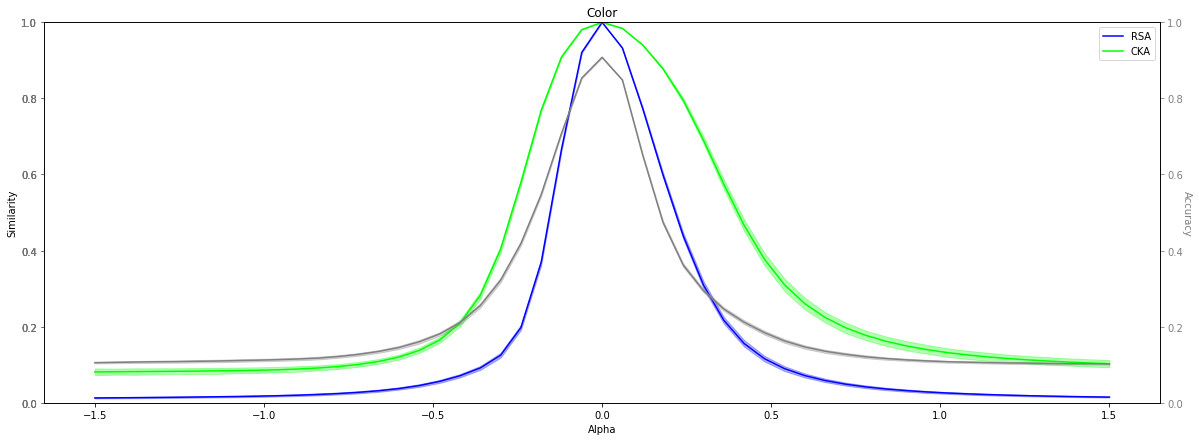

In [103]:
def plotAug(
    ax,
    x: np.ndarray,
    ys: list,
    colors: list,
    labels: list = None,
    topLabel: str = "",
    xLabel: str = "",
    yLabel: str = "",
    xlim: tuple = None,
    ylim: tuple = (0, 1),
    includeXTick: bool = False,
    includeYTick: bool = False,
    showLegend: bool = False,
):
    if labels is None:
        labels = [""] * len(ys)

    # Create lines
    for y, label, color in zip(ys, labels, colors):
        if isinstance(y, tuple): # Build CI bands
            ax.fill_between(
                x, 
                y[0], 
                y[1],
                zorder=-1,
                alpha=.3,
                color=color
            )
        else:
            ax.plot(x, y, color=color, label=label)

    # Add labels and axes
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(topLabel)
    ax.set_xlabel(xLabel)
    ax.tick_params(
        axis="x", which="both", bottom=includeXTick, labelbottom=includeXTick
    )

    # Check if we're a twin
    twinned = False
    for otherAx in ax.figure.axes:
        if otherAx is ax:
            continue
        if otherAx.bbox.bounds == ax.bbox.bounds:
            twinned = True

    if twinned:
        ax.set_ylabel(
            yLabel,
            rotation=270,
            rotation_mode="default",
            va="center",
            color=colors[0],
        )
        ax.tick_params(
            axis="y",
            which="both",
            left=includeYTick,
            right=includeYTick,
            labelleft=includeYTick,
            labelright=includeYTick,
            colors=colors[0],
        )
    else:
        ax.set_ylabel(yLabel)
        ax.tick_params(
            axis="y",
            which="both",
            left=includeYTick,
            right=includeYTick,
            labelleft=includeYTick,
            labelright=includeYTick,
        )

    # Legend!
    if showLegend:
        ax.legend()


def bootstrapCI(x, nSamples=1000):
    means = np.array([np.nanmean(np.random.choice(x, len(x))) for i in range(nSamples)])
    means = np.sort(means)
    return means[int(nSamples*.025)], means[int(nSamples*.975)]

df = pd.read_csv(
    "../outputs/masterOutput/baseline/compiled/colorAcc.csv", index_col=0
)
versions = (df.version.unique() - 25) * (3 / 50)
meanAcc = df.groupby("version")[["acc"]].agg(np.mean)
ciAcc = df.groupby("version")[["acc"]].agg(lambda x: bootstrapCI(x))

df = pd.read_csv(
    "../outputs/masterOutput/baseline/compiled/color.csv", index_col=0
)
sims = df.groupby(["layer", "version"])[
    ["do_rsaNumba", "do_linearCKANumba"]
].agg(np.mean)
simCIs = df.groupby(["layer", "version"])[
    ["do_rsaNumba", "do_linearCKANumba"]
].agg(lambda x: bootstrapCI(x))

plt.figure(figsize=(20, 7))
# ax = plt.subplot(3, 5, 1)
ax = plt.subplot(1, 1, 1)
plotAug(
    ax,
    x=versions,
    ys=[
        sims.loc[(11,)]["do_rsaNumba"], 
        sims.loc[(11,)]["do_linearCKANumba"], 
        (simCIs.loc[(11,)]['do_rsaNumba'].apply(lambda x: x[0]).to_numpy(), simCIs.loc[(11,)]['do_rsaNumba'].apply(lambda x: x[1]).to_numpy()),
        (simCIs.loc[(11,)]['do_linearCKANumba'].apply(lambda x: x[0]).to_numpy(), simCIs.loc[(11,)]['do_linearCKANumba'].apply(lambda x: x[1]).to_numpy())],
    labels=["RSA", "CKA", '', ''],
    colors=[(0, 0, 1, 1), (0, 1, 0, 1), (0, 0, 1, 1), (0, 1, 0, 1)],
    topLabel="Color",
    xLabel="Alpha",
    yLabel="Similarity",
    includeXTick=True,
    includeYTick=True,
    showLegend=True,
)
ax2 = ax.twinx()
plotAug(
    ax2,
    x=versions,
    ys=[meanAcc, (ciAcc['acc'].apply(lambda x: x[0]).to_numpy(), ciAcc['acc'].apply(lambda x: x[1]).to_numpy())],
    colors=[(0.5, 0.5, 0.5, 1), (0.5, 0.5, 0.5, 1)],
    yLabel="Accuracy",
    includeYTick=True,
)


In [49]:
funNames = ['do_rsaNumba', 'do_svcca', 'do_linearCKANumba']
directions = ['right', 'left', 'down', 'up']
transData = pd.read_csv('../outputs/masterOutput/baseline/compiled/translate.csv', index_col=0)
for fun in funNames:
    funDirs = [fun+'-'+direct for direct in directions]
    transData[fun] = transData[funDirs].mean(1)

print('Translation at 5 pixels')
print('-- Early')
print(transData[funNames].loc[(transData['layer'] == 3) & (transData['version'] == 5)].mean())
print(transData[funNames].loc[(transData['layer'] == 3) & (transData['version'] == 5)].std())
print('\n-- Middle')
print(transData[funNames].loc[(transData['layer'] == 7) & (transData['version'] == 5)].mean())
print(transData[funNames].loc[(transData['layer'] == 7) & (transData['version'] == 5)].std())
print('\n-- Late')
print(transData[funNames].loc[(transData['layer'] == 11) & (transData['version'] == 5)].mean())
print(transData[funNames].loc[(transData['layer'] == 11) & (transData['version'] == 5)].std())


Translation at 5 pixels
-- Early
do_rsaNumba          0.629864
do_svcca             0.877109
do_linearCKANumba    0.956701
dtype: float64
do_rsaNumba          0.048929
do_svcca             0.004916
do_linearCKANumba    0.001340
dtype: float64

-- Middle
do_rsaNumba          0.314262
do_svcca             0.846803
do_linearCKANumba    0.922341
dtype: float64
do_rsaNumba          0.077469
do_svcca             0.004334
do_linearCKANumba    0.009201
dtype: float64

-- Late
do_rsaNumba          0.899025
do_svcca             0.963070
do_linearCKANumba    0.964048
dtype: float64
do_rsaNumba          0.006632
do_svcca             0.001013
do_linearCKANumba    0.001322
dtype: float64


We still have a somewhat odd non-monotonic relationship between layer depth and similarity where the middle layer varies the most due to this translating the images. Nonetheless, by the final layers, we have variability just under 1 for both metrics. 

Now we take a look at variability due to dropout.

In [70]:
dropData = pd.read_csv('../outputs/masterOutput/baseline/compiled/dropout.csv', index_col=0)
dropData
print('Dropout at 0.5')
print('-- Early')
print(dropData.loc[(dropData['dropRate'] == .5) & (dropData['layer'] == 3)].iloc[:, 0:3].mean())
print(dropData.loc[(dropData['dropRate'] == .5) & (dropData['layer'] == 3)].iloc[:, 0:3].std())
print('\n-- Middle')
print(dropData.loc[(dropData['dropRate'] == .5) & (dropData['layer'] == 7)].iloc[:, 0:3].mean())
print(dropData.loc[(dropData['dropRate'] == .5) & (dropData['layer'] == 7)].iloc[:, 0:3].std())
print('\n-- Late')
print(dropData.loc[(dropData['dropRate'] == .5) & (dropData['layer'] == 11)].iloc[:, 0:3].mean())
print(dropData.loc[(dropData['dropRate'] == .5) & (dropData['layer'] == 11)].iloc[:, 0:3].std())

Dropout at 0.5
-- Early
do_rsaNumba          0.795600
do_svcca             0.641009
do_linearCKANumba    0.989110
dtype: float64
do_rsaNumba          0.007096
do_svcca             0.009036
do_linearCKANumba    0.000964
dtype: float64

-- Middle
do_rsaNumba          0.697547
do_svcca             0.582457
do_linearCKANumba    0.943620
dtype: float64
do_rsaNumba          0.016313
do_svcca             0.004169
do_linearCKANumba    0.004174
dtype: float64

-- Late
do_rsaNumba          0.924255
do_svcca             0.924350
do_linearCKANumba    0.945975
dtype: float64
do_rsaNumba          0.004241
do_svcca             0.001852
do_linearCKANumba    0.002523
dtype: float64


It seems that these models are surprispingly resilient to dropout in their representations. Note that the there are only 2 dropout layers in these networks that are turned on for this test where the output of the early layer is right after the first dropout, the output of the middle layer is right after the second dropout, and the late layer is the penultimate layer after those. It is therefore compounding in how much dropout these representations are subject to as you move later into the network. Note: this might be better off if the output is right before dropout, the story is clearer there where the early layers is essentially just going to be 1, middle has 1 dropped, and late has 2 dropped.

We can take the results of the three baseline techniques and use the lowest value of each of the tests for each metric for the late representations, as that appears to be the most consistent. Also, we expect the most variability due to any change to the architecture to be most apparent in the later layers (ie, it is unlikely the earlier layers in our case would be significantly below baseline in terms of similarity). For RSA, that is from reflection at .87 and for CKA, that is .95 from dropout.

In [72]:
# Load model seeds
modelSeeds = pd.read_csv("../outputs/masterOutput/modelSeeds.csv")
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8]

simByLayers = np.zeros((len(layers), 3, 2))
for layerI, layer in enumerate(layers):
    # Load model sims
    ckaSims = np.load(
        f"../outputs/masterOutput/similarities/simMat_l{layer}_do_linearCKANumba.npy"
    )
    ccaSims = np.load(
        f"../outputs/masterOutput/similarities/simMat_l{layer}_do_svcca.npy"
    )
    rsaSims = np.load(
        f"../outputs/masterOutput/similarities/simMat_l{layer}_do_rsaNumba.npy"
    )

    # Loop through each shuffle seed and look for mean and sd of the weight variability
    shuffleSeeds = pd.unique(modelSeeds["shuffle"])
    weightCKAMeans = np.empty(shape=(len(shuffleSeeds)))
    weightCCAMeans = np.empty(shape=(len(shuffleSeeds)))
    weightRSAMeans = np.empty(shape=(len(shuffleSeeds)))
    for i, s in enumerate(shuffleSeeds):
        modelIdx = modelSeeds["index"].loc[s == modelSeeds.shuffle]

        # Combos
        coords = list(itertools.product(modelIdx.values, modelIdx.values))
        coords = [(x, y) for x, y in coords if x > y]

        # Loop through
        weightCKAMeans[i] = np.array([ckaSims[x, y] for x, y in coords]).mean()
        weightCCAMeans[i] = np.array([ccaSims[x, y] for x, y in coords]).mean()
        weightRSAMeans[i] = np.array([rsaSims[x, y] for x, y in coords]).mean()
        
    simByLayers[layerI, 0, 0] = weightRSAMeans.mean()
    simByLayers[layerI, 1, 0] = weightCCAMeans.mean()
    simByLayers[layerI, 2, 0] = weightCKAMeans.mean()

    weightSeeds = pd.unique(modelSeeds["weight"])
    shuffleCKAMeans = np.empty(shape=(len(weightSeeds)))
    shuffleCCAMeans = np.empty(shape=(len(weightSeeds)))
    shuffleRSAMeans = np.empty(shape=(len(weightSeeds)))
    for i, s in enumerate(weightSeeds):
        modelIdx = modelSeeds["index"].loc[s == modelSeeds.weight]

        # Combos
        coords = list(itertools.product(modelIdx.values, modelIdx.values))
        coords = [(x, y) for x, y in coords if x > y]

        # Loop through
        shuffleCKAMeans[i] = np.array(
            [ckaSims[x, y] for x, y in coords]
        ).mean()
        shuffleCCAMeans[i] = np.array(
            [ccaSims[x, y] for x, y in coords]
        ).mean()
        shuffleRSAMeans[i] = np.array(
            [rsaSims[x, y] for x, y in coords]
        ).mean()

    simByLayers[layerI, 0, 1] = shuffleRSAMeans.mean()
    simByLayers[layerI, 1, 1] = shuffleCCAMeans.mean()
    
    simByLayers[layerI, 2, 1] = shuffleCKAMeans.mean()

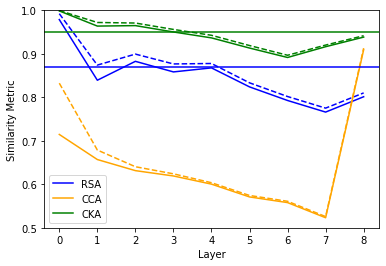

In [71]:
colors = ['blue', 'orange', 'green']
labels = ['RSA', 'CCA', 'CKA']
style = ['-', '--']

legendAx = []
plt.plot()
# Plot weight stuff
for i in range(3):
    weightLine, = plt.plot(layers, simByLayers[:, i, 0], label=labels[i], color=colors[i], linestyle=style[0])
    shuffleLine, = plt.plot(layers, simByLayers[:, i, 1], label=labels[i], color=colors[i], linestyle=style[1])
    legendAx += [weightLine]

plt.legend(handles=legendAx, loc='lower left')
plt.xlabel('Layer')
plt.ylabel('Similarity Metric')
plt.ylim(.5, 1)
plt.axhline(y=.87, color='blue', linestyle='-')
plt.axhline(y=.95, color='green', linestyle='-')
plt.show()

Above we can see the representational similarity across instances of a network at each layer depending if the shuffle seed (dotted line) or the weight seed (solid line) is manipulated. Generally, it appears that shuffle seeds cause more variability in the representations than weight seeds but only just. Another general pattern is that the randomization seeds cause more variability as you go deeper into the network. Against baseline, both CKA and RSA show that there is significant variability starting somewhere in the middle of the networks.

#### WORKSHOP // APPENDIX

In [54]:
colorData = pd.read_csv('../outputs/masterOutput/baseline/compiled/color.csv', index_col=0)
colorData.head()
print('color at alpha .24')
print('-- Early')
print(colorData.loc[((colorData['version'] == 0.24) | (colorData['version'] == -0.24)) & (colorData['layer'] == 3)].iloc[:, 1:4].mean())
print(colorData.loc[((colorData['version'] == 0.24) | (colorData['version'] == -0.24)) & (colorData['layer'] == 3)].iloc[:, 1:4].std())
print('\n-- Middle')
print(colorData.loc[((colorData['version'] == 0.24) | (colorData['version'] == -0.24)) & (colorData['layer'] == 7)].iloc[:, 1:4].mean())
print(colorData.loc[((colorData['version'] == 0.24) | (colorData['version'] == -0.24)) & (colorData['layer'] == 7)].iloc[:, 1:4].std())
print('\n-- Late')
print(colorData.loc[((colorData['version'] == 0.24) | (colorData['version'] == -0.24)) & (colorData['layer'] == 11)].iloc[:, 1:4].mean())
print(colorData.loc[((colorData['version'] == 0.24) | (colorData['version'] == -0.24)) & (colorData['layer'] == 11)].iloc[:, 1:4].std())


color at alpha .24
-- Early
do_rsaNumba          0.373696
do_svcca             0.834921
do_linearCKANumba    0.908504
dtype: float64
do_rsaNumba          0.057565
do_svcca             0.008389
do_linearCKANumba    0.020220
dtype: float64

-- Middle
do_rsaNumba          0.439901
do_svcca             0.674229
do_linearCKANumba    0.701348
dtype: float64
do_rsaNumba          0.044197
do_svcca             0.021259
do_linearCKANumba    0.035967
dtype: float64

-- Late
do_rsaNumba          0.318385
do_svcca             0.746749
do_linearCKANumba    0.687158
dtype: float64
do_rsaNumba          0.127124
do_svcca             0.047765
do_linearCKANumba    0.113658
dtype: float64


In [58]:
zoomData = pd.read_csv('../outputs/masterOutput/baseline/compiled/zoom.csv', index_col=0)
zoomData.head()
print('Zooming in 2 pixels')
print('-- Early')
print(zoomData.loc[(zoomData['layer'] == 3) & (zoomData['version'] == 2.0)].iloc[:, 1:4].mean())
print(zoomData.loc[(zoomData['layer'] == 3) & (zoomData['version'] == 2.0)].iloc[:, 1:4].std())
print('\n-- Middle')
print(zoomData.loc[(zoomData['layer'] == 7) & (zoomData['version'] == 2.0)].iloc[:, 1:4].mean())
print(zoomData.loc[(zoomData['layer'] == 7) & (zoomData['version'] == 2.0)].iloc[:, 1:4].std())
print('\n-- Late')
print(zoomData.loc[(zoomData['layer'] == 11) & (zoomData['version'] == 2.0)].iloc[:, 1:4].mean())
print(zoomData.loc[(zoomData['layer'] == 11) & (zoomData['version'] == 2.0)].iloc[:, 1:4].std())

Zooming in 2 pixels
-- Early
do_rsaNumba          0.674163
do_svcca             0.801440
do_linearCKANumba    0.904434
dtype: float64
do_rsaNumba          0.020705
do_svcca             0.005545
do_linearCKANumba    0.005580
dtype: float64

-- Middle
do_rsaNumba          0.675834
do_svcca             0.751486
do_linearCKANumba    0.875394
dtype: float64
do_rsaNumba          0.020069
do_svcca             0.005881
do_linearCKANumba    0.008484
dtype: float64

-- Late
do_rsaNumba          0.771528
do_svcca             0.906727
do_linearCKANumba    0.902801
dtype: float64
do_rsaNumba          0.014034
do_svcca             0.004082
do_linearCKANumba    0.006285
dtype: float64


## Augmentation magnitude x Accuracy tests
## DO SOME ANALYSIS WITH RESNET